# Panorama Stitcher

## Import packages

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## BGR to RGB converter

In [68]:
def convert_image(img):
    # enables mayplotlib to plot OpenCV images,
    # converts image from BGR to RGB
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return new_img

## Import images and resize

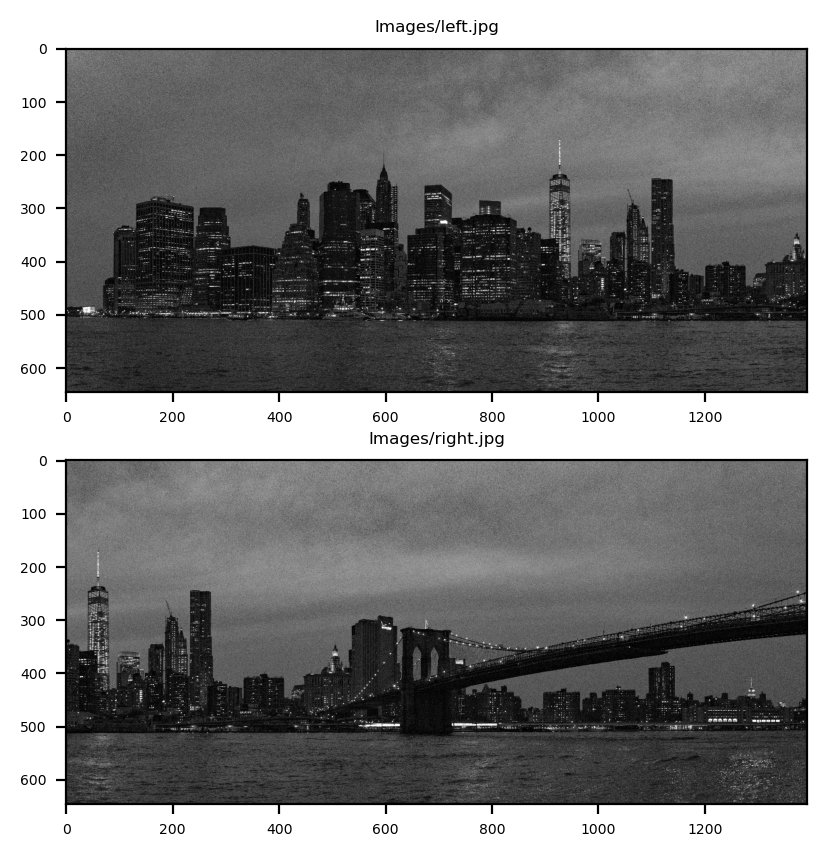

In [69]:
# import images, resize x0.5, convert to greyscale
img_ = cv2.imread("Images/left.jpg")
img_ = cv2.resize(img_, (0,0), None, 0.2, 0.2)
img1 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)

img = cv2.imread("Images/right.jpg")
img = cv2.resize(img, (0,0), None, 0.2, 0.2)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# display image
plt.rc('font', size=5)
fig, ax = plt.subplots(2, 1, figsize=(5, 5), dpi=200)
ax[0].title.set_text("Images/left.jpg")
ax[1].title.set_text("Images/right.jpg")
ax[0].imshow(convert_image(img1))
ax[1].imshow(convert_image(img2))
plt.show()

## Find keypoints

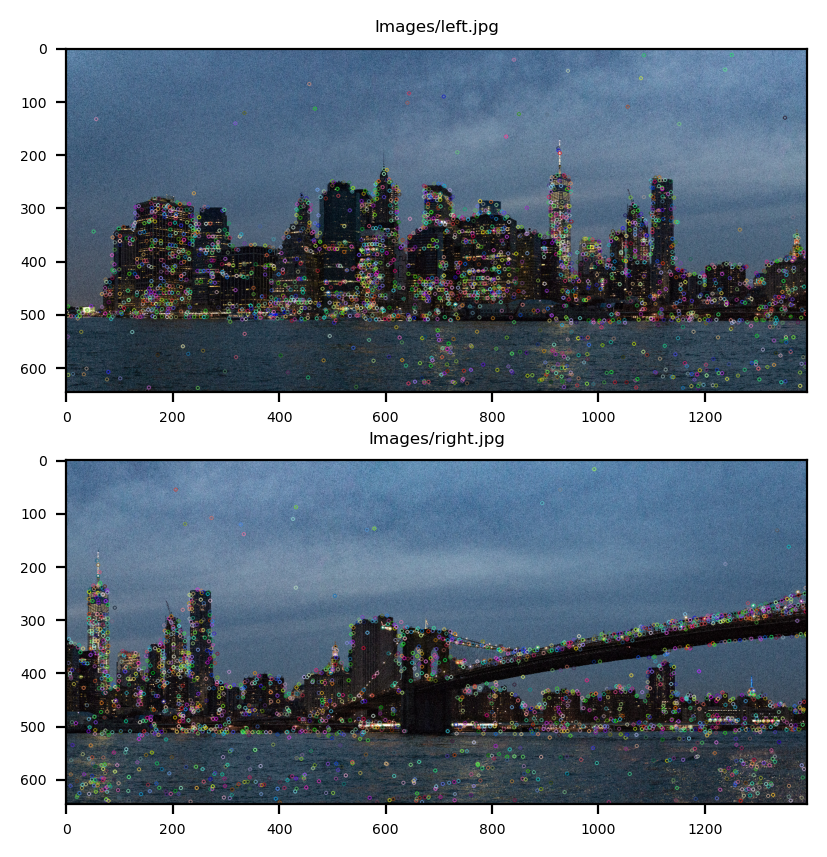

In [70]:
# set SIFT descriptor
descriptor = cv2.xfeatures2d.SIFT_create()

# get keypoints
kps1, des1 = descriptor.detectAndCompute(img1, None)
kps2, des2 = descriptor.detectAndCompute(img2, None)

# draw keypoints on images
k_img1 = cv2.drawKeypoints(img_, kps1, None)
k_img2 = cv2.drawKeypoints(img, kps2, None)

# convert and save image
k_img1 = cv2.cvtColor(k_img1, cv2.COLOR_BGR2RGB)
cv2.imwrite("Images/LeftKeypoints.png", convert_image(k_img1))

k_img2 = cv2.cvtColor(k_img2, cv2.COLOR_BGR2RGB)
cv2.imwrite("Images/RightKeypoints.png", convert_image(k_img2))

# display images
plt.rc('font', size=5)
fig, ax = plt.subplots(2, 1, figsize=(5, 5), dpi=200)
ax[0].title.set_text("Images/left.jpg")
ax[1].title.set_text("Images/right.jpg")
ax[0].imshow(k_img1)
ax[1].imshow(k_img2)
plt.show()

## Feature matching

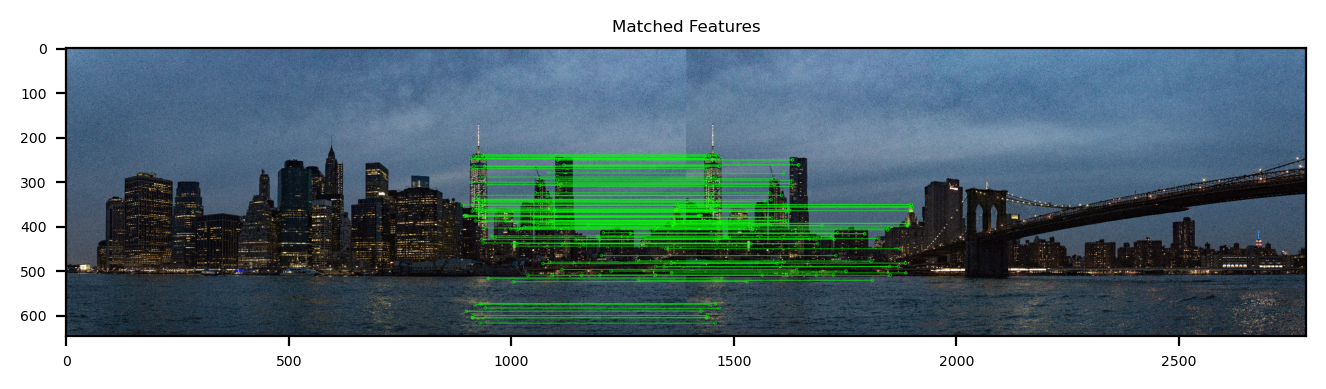

In [71]:
# set up brute force matcher
bf = cv2.BFMatcher()

# match the descriptors
raw_matches = bf.knnMatch(des1, des2, 2)

matches = []

# Lowe's ratio test
for m,n in raw_matches:
    # ensure the distance is within a certain ratio of each
    if m.distance < n.distance * 0.5:
        matches.append(m)

# match color
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, flags = 2)

# Draw first 10 matches.
match_img = cv2.drawMatches(img_, kps1, img, kps2, matches, None, **draw_params)

# convert and save image
match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
cv2.imwrite("Images/MatchedFeatures.png", convert_image(match_img))

# display image and matches
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Matched Features")
plt.imshow(match_img)
plt.show()

## Find homography (transformation matrix)

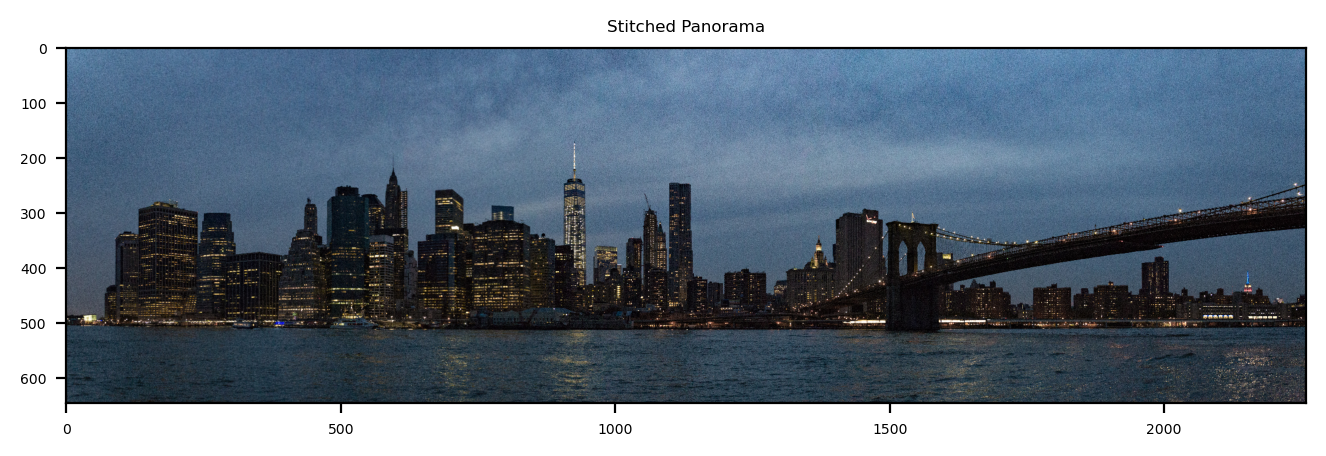

In [72]:
if len(matches) > 10:
    # construct the two sets of points
    src = np.float32([ kps1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst = np.float32([ kps2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
        
    # estimate the homography between the sets of points
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
    raise AssertionError("Can't find enough keypoints.")
    
# warp images together
def warpImages(img1, img2, H):
    # width & height
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    # find corners
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    # concatenate the points
    pts = np.concatenate((pts1, pts2_), axis=0)
    [x_min, y_min] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-x_min,-y_min]
    # translate
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])

    # apply warp perspective
    result = cv2.warpPerspective(img2, Ht.dot(H), (x_max-x_min, y_max-y_min))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result
    
# warp two images together
result = warpImages(img, img_, H)

# convert and save image
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite("Images/StitchedPanorama.png", convert_image(result))

# display stitched panorama
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Stitched Panorama")
plt.imshow(result)
plt.show()